# Healthcare Graphs Analysis
This Jupyter Notebook retrieves, processes, and visualises life expectancy and healthcare costs over the years in Singapore using data from:
- [**Life Expectancy dataset**](https://tablebuilder.singstat.gov.sg/table/TS/M810501#!)
- [**CPI dataset**](https://data.gov.sg/datasets/d_de7e93a1d0e22c790516a632747bf7f0/view?dataExplorerPage=9)
- [**Gross Income dataset**](https://data.gov.sg/datasets/d_52760e82e8786bac11cca40eb29d1a93/view)
## Libraries

In [1]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from typing import List

# Constants for API endpoints
BASE_DATA_GOV_URL = "https://data.gov.sg/api/action/datastore_search"
BASE_SINGSTAT_URL = "https://tablebuilder.singstat.gov.sg/api/table/tabledata"

## Data Retrieval Functions 

In [2]:
# function to fetch data from data.gov.sg 
def fetch_datagov_dataset(dataset_id: str, limit: int=10_000_000) -> pd.DataFrame:
    """
    Fetch dataset from data.gov.sg API.

    Args: 
        dataset_id (str): The dataset ID from data.gov.sg.
        limit (int, optional): Number of records to fetch. Defaults to 10 million.

    Returns: 
        pd.DataFrame: Data retrieved in DataFrame format.
    """
    response = requests.get(BASE_DATA_GOV_URL, params={"resource_id": dataset_id, "limit": limit})
    data = response.json()
    
    if not data["success"]:
        raise Error(f"Failed to fetch dataset ({dataset_id}).")
        
    return pd.DataFrame(data["result"]["records"])

In [3]:
def parse_singstat_2d_data(raw_data: dict) -> pd.DataFrame:
    """
    Parse the JSON data from SingStat API into a structured DataFrame.

    Args: 
        raw_data (dict): Raw JSON data from SingState API.

    Returns: 
        pd.DataFrame: Parsed DataFrame with years as columns.
    """
    rows = raw_data.get("Data", {}).get("row", [])
    records = []

    for row in rows:
        series_name = row.get("rowText", "")
        columns = row.get("columns", [])
        series_data = {col["key"]: col["value"] for col in columns}
        series_data["Series"] = series_name
        records.append(series_data)

    df = pd.DataFrame(records)
    df.set_index("Series")
    df.columns.name = "Year"
    return df

def fetch_singstat_dataset(dataset_id: str, limit: int = 10_000_000) -> pd.DataFrame:
    """ 
    Fetch dataset from SingStat API.

    Args: 
        dataset_id (str): The dataset ID from SingStat.
        limit (int, optional): Number of records to fetch. Defaults to 10 million.

    Returns:
        pd.DataFrame: Data retrieved in DataFrame format.
    """
    response = requests.get(
        f"{BASE_SINGSTAT_URL}/{dataset_id}",
        params={"limit": limit},
        headers={
            "Accept": "application/json",
            "User-Agent": "curl/8.11.1", # Need to fake the user agent because SingStat blocks `python-requests`.
        }
    )
    data = response.json()
    return parse_singstat_2d_data(data)

## Fetch Data

In [4]:
# Fetch Consumer Price Index (CPI) dataset from data.gov.sg
datagov_dataset_id = "d_de7e93a1d0e22c790516a632747bf7f0"
cpi_df = fetch_datagov_dataset(datagov_dataset_id)

# Fetch Life Expectancy dataset from SingStat
sing_stat_dataset_id = "M810501"
lx_df = fetch_singstat_dataset(sing_stat_dataset_id)

# Fetch gross income 
income_dataset_id = "d_52760e82e8786bac11cca40eb29d1a93"
income_df = fetch_datagov_dataset(income_dataset_id)

## Data Exploration CPI

In [5]:
cpi_df.head()

,_id,DataSeries,2024Dec,2024Nov,2024Oct,2024Sep,2024Aug,2024Jul,2024Jun,2024May,...,1961Oct,1961Sep,1961Aug,1961Jul,1961Jun,1961May,1961Apr,1961Mar,1961Feb,1961Jan
0,1,All Items,117.197,116.792,116.756,117.123,116.829,116.028,116.323,116.574,...,24.463,24.393,24.517,24.276,24.223,24.053,24.187,24.585,24.565,24.542
1,2,Food,119.272,118.981,118.897,118.693,118.553,118.368,118.361,118.332,...,21.614,21.506,21.699,21.323,21.242,20.967,21.172,21.82,21.777,21.762
2,3,Food Excl Food Serving Services,118.209,117.746,117.707,117.649,117.03,116.54,116.641,116.975,...,na,na,na,na,na,na,na,na,na,na
3,4,Bread & Cereals,119.91,119.717,119.428,118.818,118.12,118.209,117.849,117.711,...,na,na,na,na,na,na,na,na,na,na
4,5,Rice,105.233,104.995,104.408,105.534,103.426,104.208,103.349,104.059,...,na,na,na,na,na,na,na,na,na,na


In [6]:
cpi_df.describe()

,_id
count,152.000000
mean,76.500000
std,44.022721
min,1.000000
25%,38.750000
50%,76.500000
75%,114.250000
max,152.000000


In [7]:
cpi_df.isnull().sum()

_id           0
DataSeries    0
2024Dec       0
2024Nov       0
2024Oct       0
             ..
1961May       0
1961Apr       0
1961Mar       0
1961Feb       0
1961Jan       0
Length: 770, dtype: int64

In [8]:
cpi_df.dtypes

_id            int64
DataSeries    object
2024Dec       object
2024Nov       object
2024Oct       object
               ...  
1961May       object
1961Apr       object
1961Mar       object
1961Feb       object
1961Jan       object
Length: 770, dtype: object

## Data Exploration Life Expectancy

In [9]:
lx_df.head()

Year,1957,1960,1965,1970,1975,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Series
0,61.1,62.9,64.5,65.8,66.8,72.1,72.5,72.6,73,73.3,...,82.9,83,83.2,83.4,83.7,83.7,83.2,83,83,Total Life Expectancy At Birth (Residents)
1,59.4,61.2,62.8,64.1,65.1,69.8,70.1,70.2,70.5,70.9,...,80.5,80.7,80.9,81.2,81.4,81.3,80.8,80.7,80.7,Male Life Expectancy At Birth (Residents)
2,63.2,65,66.6,67.8,68.8,74.7,75.2,75.3,75.7,75.8,...,85.1,85.1,85.4,85.5,85.9,85.9,85.5,85.2,85.2,Female Life Expectancy At Birth (Residents)
3,8.1,8.3,8.3,8.4,8.5,14,14.2,14.2,14.4,14.6,...,20.8,20.8,21,21.2,21.4,21.3,20.9,20.7,20.7,Total Life Expectancy At Age 65 Years (Residents)
4,7.5,7.8,7.8,8,8.2,12.6,12.7,12.8,13,13.2,...,18.9,19,19.2,19.4,19.5,19.5,19.1,19,19,Male Life Expectancy At Age 65 Years (Residents)


In [10]:
lx_df.describe()

Year,1957,1960,1965,1970,1975,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Series
count,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
unique,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
top,61.1,62.9,64.5,65.8,66.8,72.1,72.5,72.6,73,73.3,...,82.9,83,83.2,83.4,83.7,83.7,83.2,83,83,Total Life Expectancy At Birth (Residents)
freq,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [11]:
lx_df.isnull().sum()

Year
1957      0
1960      0
1965      0
1970      0
1975      0
1980      0
1981      0
1982      0
1983      0
1984      0
1985      0
1986      0
1987      0
1988      0
1989      0
1990      0
1991      0
1992      0
1993      0
1994      0
1995      0
1996      0
1997      0
1998      0
1999      0
2000      0
2001      0
2002      0
2003      0
2004      0
2005      0
2006      0
2007      0
2008      0
2009      0
2010      0
2011      0
2012      0
2013      0
2014      0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
2021      0
2022      0
2023      0
Series    0
dtype: int64

In [12]:
lx_df.dtypes

Year
1957      object
1960      object
1965      object
1970      object
1975      object
1980      object
1981      object
1982      object
1983      object
1984      object
1985      object
1986      object
1987      object
1988      object
1989      object
1990      object
1991      object
1992      object
1993      object
1994      object
1995      object
1996      object
1997      object
1998      object
1999      object
2000      object
2001      object
2002      object
2003      object
2004      object
2005      object
2006      object
2007      object
2008      object
2009      object
2010      object
2011      object
2012      object
2013      object
2014      object
2015      object
2016      object
2017      object
2018      object
2019      object
2020      object
2021      object
2022      object
2023      object
Series    object
dtype: object

## Data Exploration Income

In [13]:
income_df.head()

,1996,1997,1998,1999,2001,2002,2003,2004,2006,2007,...,2017,2018,2019,2020,2021,2022,2023,2024,_id,DataSeries
0,1950,2078,2240,2026,2387,2380,2410,2326,2449,2543,...,4232,4437,4563,4534,4680,5070,5197,5500,1,Median (50th Percentile)
1,1140,1200,1300,1191,1383,1346,1334,1305,1286,1356,...,2200,2340,2457,2340,2500,2779,2826,na,2,20th Percentile


In [14]:
income_df.describe()

,_id
count,2.000000
mean,1.500000
std,0.707107
min,1.000000
25%,1.250000
50%,1.500000
75%,1.750000
max,2.000000


In [15]:
lx_df.isnull().sum()

Year
1957      0
1960      0
1965      0
1970      0
1975      0
1980      0
1981      0
1982      0
1983      0
1984      0
1985      0
1986      0
1987      0
1988      0
1989      0
1990      0
1991      0
1992      0
1993      0
1994      0
1995      0
1996      0
1997      0
1998      0
1999      0
2000      0
2001      0
2002      0
2003      0
2004      0
2005      0
2006      0
2007      0
2008      0
2009      0
2010      0
2011      0
2012      0
2013      0
2014      0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
2021      0
2022      0
2023      0
Series    0
dtype: int64

In [16]:
lx_df.dtypes

Year
1957      object
1960      object
1965      object
1970      object
1975      object
1980      object
1981      object
1982      object
1983      object
1984      object
1985      object
1986      object
1987      object
1988      object
1989      object
1990      object
1991      object
1992      object
1993      object
1994      object
1995      object
1996      object
1997      object
1998      object
1999      object
2000      object
2001      object
2002      object
2003      object
2004      object
2005      object
2006      object
2007      object
2008      object
2009      object
2010      object
2011      object
2012      object
2013      object
2014      object
2015      object
2016      object
2017      object
2018      object
2019      object
2020      object
2021      object
2022      object
2023      object
Series    object
dtype: object

## Life Expectancy vs Healthcare Cost
## Data Cleaning & Processing

In [17]:
def get_yearly_avg(cpi_df: pd.DataFrame, y_range: int = 11) -> pd.DataFrame:
    """
    Calculate yearly average healthcare costs from monthly CPI data.

    Args:
        cpi_df (pd.DataFrame): CPI dataset.
        y_range (int, optional): Number of years to consider. Defaults to 11.

    Returns: 
        pd.DataFrame: Yearly average healthcare cost.
    """
    current_year = 2023
    year_range = [str(current_year-x) for x in range(y_range)]

    yearly_avg = {}
    for year in year_range:
        month_col = [col for col in cpi_df.columns if col.startswith(year)]

        if month_col: 
            cpi_df[month_col] = cpi_df[month_col].apply(pd.to_numeric)
            yearly_avg[year] = cpi_df[month_col].sum(axis=1) / len(month_col)
            
    return pd.DataFrame(yearly_avg)


In [18]:
def format_life_expectancy(lx_df: pd.DataFrame, series_name: str ,y_range: int=11) -> pd.DataFrame:
    """
    Format and filter Life Expectancy dataset.

    Args:
        lx_df (pd.DataFrame): Life Expectancy dataset.
        series_name (str): The series name to extract. 
        y_range (int, optional): Number of years to soncider. Default to 11.

    Returns: 
        pd.DataFrame: Filtered and formatted DataFrame.
    """
    formated_df = lx_df[lx_df["Series"] == series_name].drop(columns=["Series"])
    years_to_use = [str(2023-x) for x in range(y_range)]

    return formated_df[years_to_use]

In [19]:
# Filter CPI dataset to retain only healthcare data
health_care_df = cpi_df[cpi_df['DataSeries'].str.contains("Health Care")].reset_index(drop=True)

# Calculate yearly healthcare cost average
hc_yearly_df = get_yearly_avg(health_care_df, y_range=22)

In [20]:
# Format life expectancy data
series_name = "Total Life Expectancy At Birth (Residents)"
lx_yearly_df = format_life_expectancy(lx_df, series_name, y_range=22)

In [21]:
# Clean and merge both datasets
lx_yearly_df = lx_yearly_df.reset_index(drop=True)
merged_df = pd.concat([lx_yearly_df, hc_yearly_df])
merged_df.index = ["Life Expectancy", "Healthcare Average"]

In [22]:
# Transpose and format for visualisation 
merged_df = merged_df.T.reset_index().rename(columns={"index": "Year"})

In [23]:
# Make sure all numbers are numeric.
merged_df = merged_df.apply(pd.to_numeric)

In [24]:
merged_df = merged_df[merged_df["Year"] >= 2014]
merged_df

,Year,Life Expectancy,Healthcare Average
0,2023,83.0,106.321417
1,2022,83.0,101.746167
2,2021,83.2,99.579250
3,2020,83.7,98.463417
4,2019,83.7,99.999917
5,2018,83.4,98.905250
6,2017,83.2,96.924333
7,2016,83.0,94.566083
8,2015,82.9,93.560417
9,2014,82.6,93.639500


## Visualisation

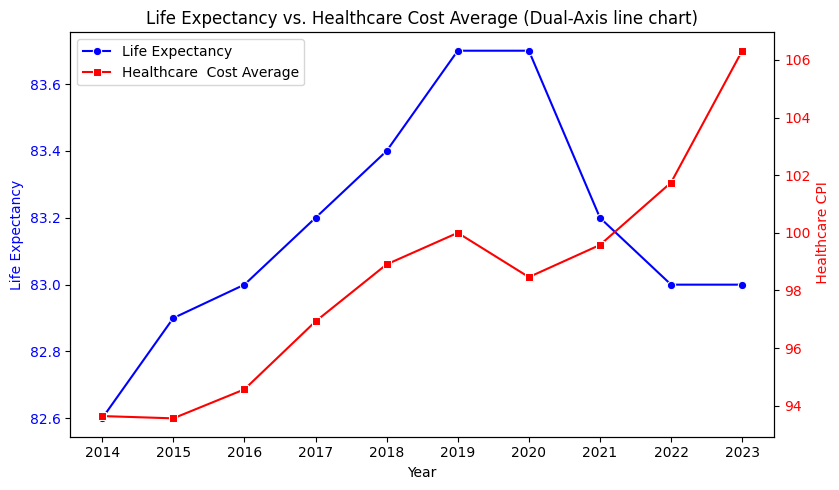

In [39]:
# Dual-axis line chart
fig1, ax1 = plt.subplots(figsize=(10, 5))

# First Line: Life Expectancy 
sns.lineplot(data=merged_df, x="Year", y="Life Expectancy", marker="o", ax=ax1, color="blue", label="Life Expectancy", legend=False)  
ax1.set_ylabel("Life Expectancy", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Second Line: Healthcare Cost Average
ax2 = ax1.twinx()
sns.lineplot(data=merged_df, x="Year", y="Healthcare Average", marker='s', ax=ax2, color="red", label="Healthcare  Cost Average", legend=False)
ax2.set_ylabel(" Healthcare CPI", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Legend & Labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0)

# Title and Layout 
ax1.set_xlabel("Year")
ax1.set_title("Life Expectancy vs. Healthcare Cost Average (Dual-Axis line chart)")
fig1.tight_layout(rect=[0, 0, 0.85, 1])

# Make x-axis ticks use a step size of 1.
ax1.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))

# Show plot
plt.show()

## Healthcare Cost vs Income Growth
## Data Cleaning & Processing

In [26]:
def process_income(income_df: pd.DataFrame, row_name: str, year_range: int = 11, skip_years: list[str] = []) -> pd.DataFrame:
    income_df["DataSeries"].str.strip()
    gross_income_df = income_df[income_df["DataSeries"].str.contains(row_name)].reset_index(drop=True)
    gross_income_df = gross_income_df.drop(columns=["_id"], errors="ignore")

    current_year = 2024
    # y_range = [str(current_year-x) for x in range(year_range)]
    available_years = set(map(str, income_df.columns))
    y_range = [
        str(current_year - x)
        for x in range(year_range)
        if str(current_year - x) in available_years and str(current_year - x) not in map(str, skip_years)
    ]

    gross_income_df.index = ["Income"]
    
    return gross_income_df[y_range]

In [27]:
def process_healthcare(cpi_df: pd.DataFrame, row_lists: List[str], year_range: int = 11, skip_years: List[str] = []) -> pd.DataFrame: 
    cpi_df["DataSeries"] = cpi_df["DataSeries"].str.strip()
    hc_df = cpi_df[cpi_df["DataSeries"].isin(row_lists)].reset_index(drop=True)
    hc_df = hc_df.drop(columns=["_id"], errors="ignore")

    current_year = 2024
    # y_range = [str(current_year-x) for x in range(year_range)]
    available_years = {col[:4] for col in cpi_df.columns if col[:4].isdigit()}
    y_range = [
        str(current_year - x)
        for x in range(year_range)
        if str(current_year - x) in available_years and str(current_year - x) not in map(str, skip_years)
    ]

    yearly_avg = {}
    row_names  = []
    for index, row in hc_df.iterrows():
        row_name = row["DataSeries"]
        row_names.append(row_name)

        yearly_avg[row_name] = {}


        for year in y_range: 
            month_col = [col for col in hc_df.columns if col.startswith(year)]
            if month_col: 
                row_data = pd.to_numeric(row[month_col], errors="coerce").dropna()

                if not row_data.empty: 
                    yearly_avg[row_name][year] = row_data.mean()
                else:
                    yearly_avg[row_name][year] = None

    return pd.DataFrame(yearly_avg).T

In [28]:
process_income_df = process_income(income_df, "Median", year_range=22, skip_years=["2005"])
process_income_df

,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,...,2013,2012,2011,2010,2009,2008,2007,2006,2004,2003
Income,5500,5197,5070,4680,4534,4563,4437,4232,4056,3949,...,3705,3480,3249,3000,2927,2897,2543,2449,2326,2410


In [29]:
health_care_col = [
    "Medicines & Health Products",
    "Outpatient Services",
    "Hospital Services",
    "Health Insurance"
]
process_healthcare_df = process_healthcare(cpi_df=cpi_df, row_lists=health_care_col, year_range=22, skip_years=["2005"])
process_healthcare_df

,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,...,2013,2012,2011,2010,2009,2008,2007,2006,2004,2003
Medicines & Health Products,102.834750,101.306083,99.857500,98.604833,98.581417,99.999917,100.924333,100.731167,100.840917,100.897417,...,99.256583,97.138917,94.728667,92.319833,91.144917,90.971250,86.123167,82.548833,81.009250,79.934833
Outpatient Services,109.617083,105.436000,99.498417,96.811250,96.486083,99.999917,98.475917,96.724667,94.401167,91.819250,...,93.514417,90.556667,86.122083,84.086000,82.065667,79.867583,75.734583,72.932833,71.943250,65.686417
Hospital Services,114.925583,109.641083,104.920000,102.997917,101.484833,99.999917,97.902000,94.333417,90.344500,90.060583,...,82.901333,79.304667,74.252667,72.100083,70.699583,69.303167,64.837917,61.435667,60.497667,59.925500
Health Insurance,116.440583,110.809667,106.945333,104.903833,100.009167,100.000000,99.943000,99.507167,97.920000,97.417000,...,95.086083,89.021000,88.987000,88.490500,88.155333,86.883750,86.627000,86.936000,86.938667,NaN


### Merge income and healthcare

In [30]:
income_healthcare_df = pd.concat([process_income_df, process_healthcare_df])
income_healthcare_df = income_healthcare_df.transpose()
income_healthcare_df = income_healthcare_df[::-1]

# Convert to numeric because all the data are strings.
income_healthcare_df = income_healthcare_df.apply(pd.to_numeric, errors="coerce")

# Convert index to number.
income_healthcare_df.index = income_healthcare_df.index.astype(int)

# Filter to 2014 and beyond.
income_healthcare_df = income_healthcare_df[income_healthcare_df.index >= 2014]

income_healthcare_df

,Income,Medicines & Health Products,Outpatient Services,Hospital Services,Health Insurance
2014,3770,100.061333,95.522500,87.347333,97.464750
2015,3949,100.897417,91.819250,90.060583,97.417000
2016,4056,100.840917,94.401167,90.344500,97.920000
2017,4232,100.731167,96.724667,94.333417,99.507167
2018,4437,100.924333,98.475917,97.902000,99.943000
2019,4563,99.999917,99.999917,99.999917,100.000000
2020,4534,98.581417,96.486083,101.484833,100.009167
2021,4680,98.604833,96.811250,102.997917,104.903833
2022,5070,99.857500,99.498417,104.920000,106.945333
2023,5197,101.306083,105.436000,109.641083,110.809667


## Visualisation

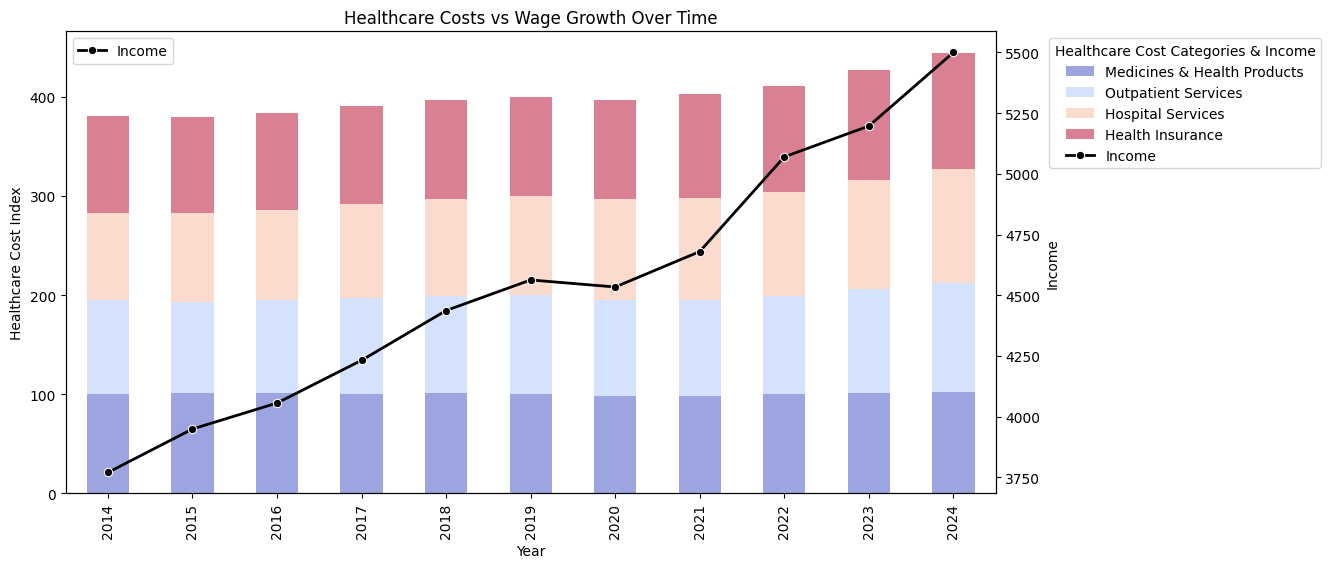

In [46]:
fig2, ax3 = plt.subplots(figsize=(12,6))

# stackbar chart
income_healthcare_df[["Medicines & Health Products", "Outpatient Services", "Hospital Services", "Health Insurance"]].plot(kind="bar", stacked=True, alpha=0.5, ax=ax3, cmap="coolwarm")
ax3.set_ylabel("Healthcare Cost Index")

# label and title
ax3.set_xlabel("Year")
ax3.set_title("Healthcare Costs vs Wage Growth Over Time")

# show legend
# ax3.legend(title="Healthcare Cost Categories", bbox_to_anchor=(1.05, 1), loc="upper left")


# line chart for income
# `ax3.get_xticks()` must be specified as the x values.
# See: # https://stackoverflow.com/questions/49894161/line-doesnt-show-over-barplot
ax4 = ax3.twinx()
sns.lineplot(x=ax3.get_xticks(), y=income_healthcare_df["Income"], marker="o", color="black", linewidth=2, ax=ax4, label="Income")
ax4.set_ylabel("Income", color="black")

# add legend 
# ax4.legend(title="Income", bbox_to_anchor=(1.05, 0.85), loc="upper left")
handles1, labels1 = ax3.get_legend_handles_labels()
handles2, labels2 = ax4.get_legend_handles_labels()

handles = handles1 + handles2
labels = labels1 + labels2

ax3.legend(handles, labels, title="Healthcare Cost Categories & Income", bbox_to_anchor=(1.05, 1), loc="upper left")
           
# Rotate x axis labels 
plt.xticks(rotation=45)

plt.show()

### Percentage change healthcare Costs vs Wage Growth 

In [32]:
row_list = [
    "Health Care"
]
healthcare_df = process_healthcare(cpi_df=cpi_df, row_lists=row_list, year_range=22, skip_years=["2005"])
healthcare_df = healthcare_df.transpose()
healthcare_df = healthcare_df[::-1]
healthcare_df["Health Care % Change"] = healthcare_df["Health Care"].pct_change() * 100
healthcare_df.index = healthcare_df.index.set_names("Year")
healthcare_df.index = pd.to_numeric(healthcare_df.index)
healthcare_df

,Health Care,Health Care % Change
Year,,
2003,67.499417,NaN
2004,71.255250,5.564246
2006,72.256250,1.404809
2007,75.180250,4.046709
2008,79.274667,5.446133
2009,80.712083,1.813211
2010,82.169833,1.806111
2011,84.119000,2.372120
2012,87.786333,4.359697


In [33]:
temp_income_df = process_income_df.stack().reset_index()
temp_income_df= temp_income_df.drop("level_0", axis=1)
temp_income_df = temp_income_df.rename({
    "level_1": "Year",
    0: "Income",
}, axis=1)
temp_income_df = temp_income_df.apply(pd.to_numeric)
temp_income_df = temp_income_df.sort_values("Year")
temp_income_df["Income % Change"] = temp_income_df["Income"].pct_change() * 100
temp_income_df = temp_income_df.set_index("Year")
temp_income_df

,Income,Income % Change
Year,,
2003,2410,NaN
2004,2326,-3.485477
2006,2449,5.288048
2007,2543,3.838301
2008,2897,13.920566
2009,2927,1.035554
2010,3000,2.494021
2011,3249,8.300000
2012,3480,7.109880


In [34]:
# healthcare_income_percentage_df = pd.concat([healthcare_df, temp_income_df])
# healthcare_income_percentage_df.loc["2003"]
# healthcare_income_percentage_df = healthcare_income_percentage_df.drop(healthcare_income_percentage_df.loc["2003"].index)
# healthcare_income_percentage_df

healthcare_income_percentage_df = pd.merge(healthcare_df, temp_income_df, left_index=True, right_index=True, how="outer")

healthcare_income_percentage_df = healthcare_income_percentage_df.drop("2003", errors="ignore")

# Convert year to integer.
healthcare_income_percentage_df.index = healthcare_income_percentage_df.index.astype(int)

# Set index name to "Year".
healthcare_income_percentage_df.index = healthcare_income_percentage_df.index.set_names(["Year"])

# Filter to 2014 and beyond.
healthcare_income_percentage_df = healthcare_income_percentage_df[
    healthcare_income_percentage_df.index >= 2014
]
healthcare_income_percentage_df

,Health Care,Health Care % Change,Income,Income % Change
Year,,,,
2014,93.639500,2.768607,3770,1.754386
2015,93.560417,-0.084455,3949,4.748011
2016,94.566083,1.074885,4056,2.709547
2017,96.924333,2.493759,4232,4.339250
2018,98.905250,2.043776,4437,4.844045
2019,99.999917,1.106783,4563,2.839757
2020,98.463417,-1.536501,4534,-0.635547
2021,99.579250,1.133247,4680,3.220115
2022,101.746167,2.176072,5070,8.333333


In [35]:
# Unpivot to long format in preparation for the category plot.
healthcare_income_percentage_df = healthcare_income_percentage_df.reset_index().melt(
    id_vars="Year",
    value_vars=["Health Care % Change", "Income % Change"],
    var_name="Category",
    value_name="% Change"
)
healthcare_income_percentage_df = healthcare_income_percentage_df.replace("Health Care % Change", "Healthcare")
healthcare_income_percentage_df = healthcare_income_percentage_df.replace("Income % Change", "Income")
healthcare_income_percentage_df

,Year,Category,% Change
0,2014,Healthcare,2.768607
1,2015,Healthcare,-0.084455
2,2016,Healthcare,1.074885
3,2017,Healthcare,2.493759
4,2018,Healthcare,2.043776
5,2019,Healthcare,1.106783
6,2020,Healthcare,-1.536501
7,2021,Healthcare,1.133247
8,2022,Healthcare,2.176072
9,2023,Healthcare,4.496730


### Visualisation 

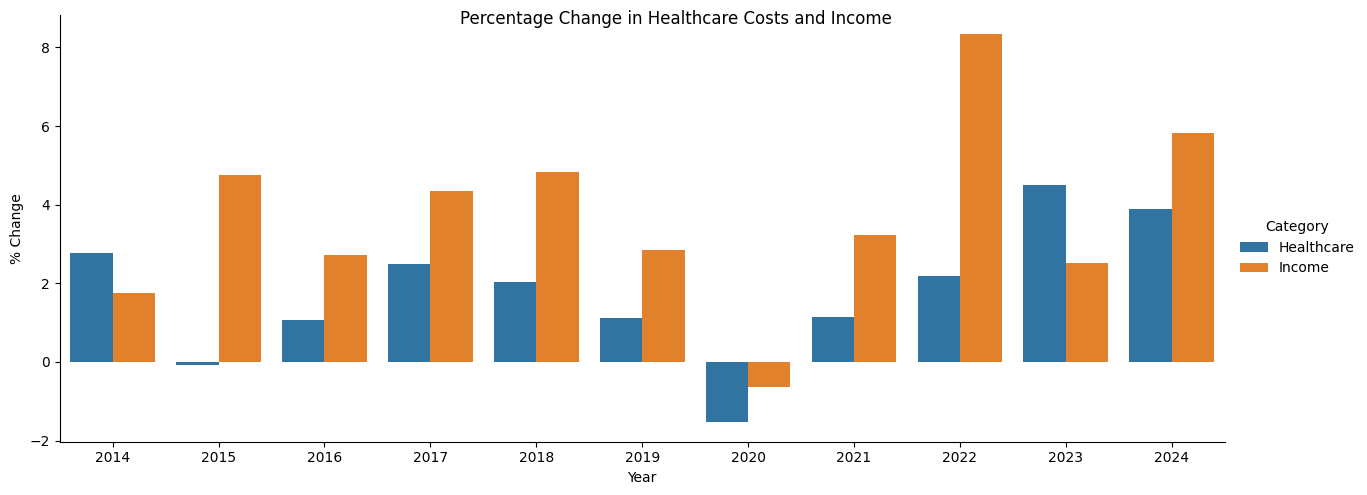

In [36]:
catplot = sns.catplot(
    data=healthcare_income_percentage_df,
    x="Year",
    y="% Change",
    hue="Category",
    kind="bar",
    height=5,
    aspect=2.5,
)
catplot.fig.suptitle("Percentage Change in Healthcare Costs and Income")
plt.show()

## Breakdown of Healthcare CPI 

In [37]:
healthcare_cols = [
    "Medicines & Health Products",
    "Medicines & Vitamins",
    "Medical Products",
    "Outpatient Services",
    "Fees At Polyclinics",
    "Fees At GP Clinics",
    "Fees At Specialist Clinics",
    "Dental Services",
    "Paramedical Services",
    "Hospital Services",
    "Health Insurance"
]

all_healthcare_df = process_healthcare(cpi_df=cpi_df, row_lists=healthcare_cols, year_range=22)
all_healthcare_df = all_healthcare_df.fillna(method="ffill")
all_healthcare_df = all_healthcare_df.transpose()
all_healthcare_df = all_healthcare_df[::-1]

# Convert year index to integer.
all_healthcare_df.index = all_healthcare_df.index.astype(int)

# Filter to 2014 and beyond.
all_healthcare_df = all_healthcare_df[all_healthcare_df.index >= 2014]

all_healthcare_df

/tmp/ipykernel_3550/2731860475.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_healthcare_df = all_healthcare_df.fillna(method="ffill")


,Medicines & Health Products,Medicines & Vitamins,Medical Products,Outpatient Services,Fees At Polyclinics,Dental Services,Paramedical Services,Hospital Services,Health Insurance
2014,100.061333,99.728917,101.250833,95.522500,175.938667,96.751083,87.350500,87.347333,97.464750
2015,100.897417,100.788167,101.291250,91.819250,95.836167,95.718667,88.897083,90.060583,97.417000
2016,100.840917,100.942000,100.484333,94.401167,97.620000,97.164083,92.767167,90.344500,97.920000
2017,100.731167,100.913167,100.083750,96.724667,99.535417,98.539833,96.320583,94.333417,99.507167
2018,100.924333,101.266417,99.706500,98.475917,100.181417,99.995083,97.976500,97.902000,99.943000
2019,99.999917,100.000000,100.000083,99.999917,100.000000,100.000083,100.000167,99.999917,100.000000
2020,98.581417,98.091083,100.119917,96.486083,89.058583,95.190000,101.056833,101.484833,100.009167
2021,98.604833,98.386250,99.290500,96.811250,88.619250,97.371333,101.941500,102.997917,104.903833
2022,99.857500,99.783417,100.090417,99.498417,94.428083,100.894917,104.590833,104.920000,106.945333
2023,101.306083,101.556583,100.520000,105.436000,107.521667,107.464917,111.003167,109.641083,110.809667


### Visualisation 

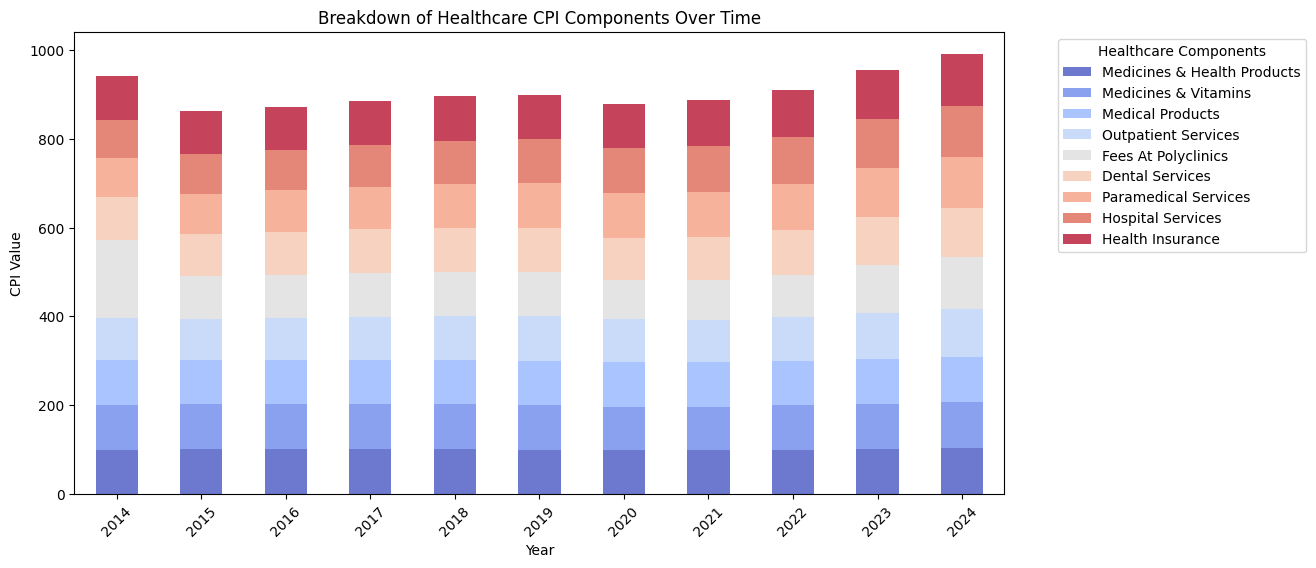

In [38]:
fig4, ax7 = plt.subplots(figsize=(12,6))

all_healthcare_df.plot(kind="bar", stacked=True, ax=ax7, cmap="coolwarm", alpha=0.75)

ax7.set_xlabel("Year")
ax7.set_ylabel("CPI Value")
ax7.set_title("Breakdown of Healthcare CPI Components Over Time")

ax7.legend(title="Healthcare Components", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks(rotation=45)

plt.show()